In [1]:
%matplotlib widget
import numpy as np
import pyabf
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import numpy as np
import pyabf


Load

In [98]:
# Variables
vr_detect_lb = 0.04      # Spike detection threshold lower bound (positive threshold)
isi_min = 0.1
isi_max = 0.2            # Maximum inter-spike interval within a burst (seconds)
bst_spknum_min = 2       # Minimum number of spikes within a burst
scale_bar_time = 0.2     # Scale bar duration (seconds)

# Load ABF file (update file path accordingly)
abf_file_path = r'C:\Maha\DATA\vnr\analysis\3s_control_2025\25n25009.abf'
abf = pyabf.ABF(abf_file_path)

# Combine all sweeps into a single trace
vr = np.concatenate([abf.setSweep(sweepNumber) or abf.sweepY 
                     for sweepNumber in range(abf.sweepCount)])
sr = abf.dataRate  # Sampling rate (Hz)
t = np.arange(len(vr)) / sr  # Time vector

print("Data loaded:")
print("  Trace length:", len(vr))
print("  Sampling rate:", sr)

# Compute file name from the file path.
file_name = os.path.basename(abf_file_path)  # e.g., "23n30005.abf"
print("File name:", file_name)

# Determine condition based on the directory path.
if "3s_control" in abf_file_path:
    condition = "control"
elif "3s_opsin" in abf_file_path:
    condition = "opsin"
else:
    condition = "unknown"

print("Condition:", condition)

# Create an output directory based on the file name (without extension).
file_base = os.path.splitext(file_name)[0]  # e.g., "23n30005"
output_dir = os.path.join(os.path.dirname(abf_file_path), f"output_{file_base}")

# Create the directory if it does not exist.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Output directory created:", output_dir)


Data loaded:
  Trace length: 3800000
  Sampling rate: 5000
File name: 25n25009.abf
Condition: control
Output directory created: C:\Maha\DATA\vnr\analysis\3s_control_2025\output_25n25009


In [99]:
# Use the full trace for analysis (no interactive selection)
vr_trace = vr
t_trace = t
print("Using the full trace for analysis.")



Using the full trace for analysis.


envelope

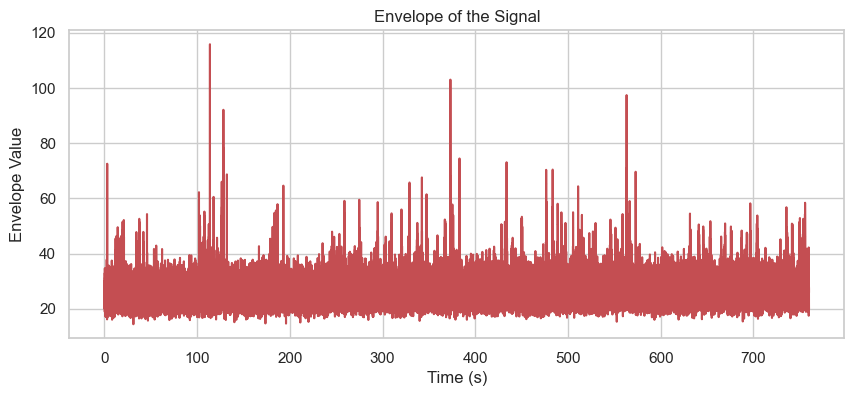

In [100]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Use your actual data variables: vr_trace (signal) and t_trace (time vector)
# Compute the envelope with a sliding window of n samples
n = 100  # window size
env = np.array([np.max(vr_trace[i:i+n]) - np.min(vr_trace[i:i+n])
                for i in range(len(vr_trace) - n + 1)])
env_time = t_trace[:len(env)]  # corresponding time vector for the envelope



In [101]:
# Estimate noise level from the envelope (e.g., the minimum envelope value)
noise_level = np.min(env)
# Set the threshold as 0.2 times the estimated noise level (adjust multiplier as needed)
threshold_value = 2.5* noise_level

print("Estimated noise level (min envelope):", noise_level)
print("Manually set threshold (2.5 x noise level):", threshold_value)



Estimated noise level (min envelope): 14.395142
Manually set threshold (2.5 x noise level): 50.382996


In [102]:
# Create a binary array: True where the envelope is above the manually set threshold
bout_bool = env > threshold_value
bout_indices = np.where(bout_bool)[0]

if bout_indices.size == 0:
    print("No bouts detected!")
else:
    print("Indices above threshold:", bout_indices)


Indices above threshold: [  14746   14747   14748 ... 3778751 3778752 3778753]


Bout detection

In [103]:
# Define a gap threshold (e.g., 500 samples) for separating bouts
gap_threshold = 500

# Identify gaps between successive indices
diff_bout = np.diff(bout_indices)
gap_indices = np.where(diff_bout > gap_threshold)[0]

bout_boundaries = []
if len(gap_indices) == 0:
    bout_boundaries.append((bout_indices[0], bout_indices[-1]))
else:
    bout_boundaries.append((bout_indices[0], bout_indices[gap_indices[0]]))
    for i in range(len(gap_indices) - 1):
        start = bout_indices[gap_indices[i] + 1]
        end = bout_indices[gap_indices[i + 1]]
        bout_boundaries.append((start, end))
    bout_boundaries.append((bout_indices[gap_indices[-1] + 1], bout_indices[-1]))

bout_boundaries = np.array(bout_boundaries)
print("Detected bout boundaries (indices):", bout_boundaries)


Detected bout boundaries (indices): [[  14746   14845]
 [  97673   97768]
 [ 103781  104318]
 ...
 [3768950 3769046]
 [3777935 3778031]
 [3778657 3778753]]


In [105]:
import os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Name of the output PDF file
pdf_filename = "detected_bouts.pdf"
pdf_file_path = os.path.join(output_dir, pdf_filename)

with PdfPages(pdf_file_path) as pdf:
    for i, bout in enumerate(bout_boundaries):
        start_idx, end_idx = bout
        # Create a new figure for each bout
        fig, ax = plt.subplots(figsize=(10, 5))
        
        # Plot the envelope segment corresponding to the bout
        ax.plot(env_time[start_idx:end_idx+1], env[start_idx:end_idx+1], 'r-', label='Envelope')
        
        # Calculate duration of the bout (in seconds)
        bout_duration = env_time[end_idx] - env_time[start_idx]
        
        # Set title and labels
        ax.set_title(f"Bout {i+1}: Duration = {bout_duration:.3f} s (Indices: {start_idx} - {end_idx})")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Envelope Value")
        ax.legend()
        
        # Save the current figure to the PDF and then close it
        pdf.savefig(fig)
        plt.close(fig)

print(f"All detected bouts have been saved to {pdf_file_path}.")



All detected bouts have been saved to C:\Maha\DATA\vnr\analysis\3s_control_2025\output_25n25009\detected_bouts.pdf.


computing_parameters

In [110]:
import numpy as np

# Ensure VNRData exists; if not, create an empty dictionary.
try:
    VNRData
except NameError:
    VNRData = {}

# -------------------------------
# ASSUMPTIONS:
#   vr_trace       : 1D numpy array of the selected trace
#   env            : envelope of vr_trace computed using a sliding window
#   threshold_value: manually determined threshold for bout detection (a float)
#   sr             : sampling rate (e.g. 1.0e4 for 10 kHz, 5.0e3 for 5 kHz)
#   gap_threshold  : gap (in samples) used to separate bouts; e.g., 1000 for 10 kHz (or 500 for 5 kHz)
#   (Other variables such as vr_fulltrace, file_name, experiment_info are assumed to be defined)
# -------------------------------

# Set the gap threshold; for a 5 kHz sampling rate, 500 samples = 0.1 s separation.
gap_threshold = 500

# --- Step 1: Bout Detection from the Envelope ---
# Create a boolean mask where the envelope exceeds the threshold.
thres = env > threshold_value
# Find the indices where the envelope is above threshold.
thres2 = np.where(thres)[0]

if thres2.size == 0:
    raise ValueError("No bouts detected: no envelope values exceed the threshold.")

# Compute differences between successive indices in thres2.
Diff_thres = np.diff(thres2)
# Identify where gaps exceed gap_threshold to determine bout breaks.
Find_events = np.where(Diff_thres > gap_threshold)[0]

# Determine bout boundaries and durations based on the detected gaps.
if Find_events.size == 0:
    # Only one bout detected: from the first to the last index in thres2.
    Bouts_Duration = np.array([thres2[-1] - thres2[0]])
    PositionBouts = np.array([[thres2[0], thres2[-1]]])
elif Find_events.size == 1:
    # Two bouts detected.
    Bouts_Duration = np.array([
        thres2[Find_events[0]] - thres2[0],
        thres2[-1] - thres2[Find_events[0] + 1]
    ])
    PositionBouts = np.array([
        [thres2[0], thres2[Find_events[0] - 1]],
        [thres2[Find_events[0] + 1], thres2[-1]]
    ])
else:
    # More than two bouts detected.
    Bouts_Duration_list = []
    PositionBouts_list = []
    # First bout:
    Bouts_Duration_list.append(thres2[Find_events[0]] - thres2[0])
    PositionBouts_list.append([thres2[0], thres2[Find_events[0] - 1]])
    # Middle bouts:
    for i in range(len(Find_events) - 1):
        Bouts_Duration_list.append(thres2[Find_events[i + 1]] - thres2[Find_events[i] + 1])
        PositionBouts_list.append([thres2[Find_events[i] + 1], thres2[Find_events[i + 1]]])
    # Last bout:
    Bouts_Duration_list.append(thres2[-1] - thres2[Find_events[-1] + 1])
    PositionBouts_list.append([thres2[Find_events[-1] + 1], thres2[-1]])
    
    Bouts_Duration = np.array(Bouts_Duration_list)
    PositionBouts = np.array(PositionBouts_list)

# Convert bout durations from samples to seconds.
Bouts_Duration_sec = Bouts_Duration / sr
# Determine the number of bouts.
Number_Bouts = Bouts_Duration_sec.size

# --- Step 2: Calculation of Instantaneous Swimming Frequencies ---
# Convert the boolean mask to integers and compute its difference.
diff_thres = np.diff(thres.astype(int))
# Find rising (start) and falling (end) edges.
PosDiff = np.where(diff_thres > 0)[0]
NegDiff = np.where(diff_thres < 0)[0]

# Ensure the number of rising and falling edges match.
min_len = min(PosDiff.size, NegDiff.size)
# Calculate the median (in samples) between rising and falling edges.
Median = (NegDiff[:min_len] - PosDiff[:min_len]) / 2.0
# Estimate the center (in sample indices) of each detected event.
XMedian = PosDiff[:min_len] + Median

# Compute instantaneous frequency: inverse of the time difference (in seconds) between successive medians.
if XMedian.size > 1:
    delta_time = np.diff(XMedian) / sr
    Freq = 1 / delta_time
    # For plotting, compute the midpoint between successive medians.
    XFreq = XMedian[:-1] + np.diff(XMedian) / 2
else:
    Freq = np.array([])
    XFreq = np.array([])

# Remove instantaneous frequencies below 9 Hz as outliers.
Freq_good = Freq[Freq >= 9]

# Split the frequency values per bout.
SwimFrequencies_per_Bout = {}
if Number_Bouts == 1:
    SwimFrequencies_per_Bout[0] = Freq_good
else:
    Freq_outliers = np.where(Freq < 9)[0]
    if Freq_outliers.size == 0:
        SwimFrequencies_per_Bout[0] = Freq_good
    else:
        bouts = []
        start_idx = 0
        for out_idx in Freq_outliers:
            if out_idx > start_idx:
                bouts.append(Freq_good[start_idx:out_idx])
            start_idx = out_idx + 1
        if start_idx < Freq_good.size:
            bouts.append(Freq_good[start_idx:])
        for i, bout in enumerate(bouts):
            SwimFrequencies_per_Bout[i] = bout

# Compute the average frequency for each bout.
AverageSwimFreq_per_Bout = {}
for i, freqs in SwimFrequencies_per_Bout.items():
    if freqs.size > 0:
        AverageSwimFreq_per_Bout[i] = np.mean(freqs)
    else:
        AverageSwimFreq_per_Bout[i] = np.nan

# --- Save Computed Results to VNRData Dictionary ---
VNRData["gap_threshold"] = gap_threshold
VNRData["Bouts_Duration"] = Bouts_Duration_sec
VNRData["PositionBouts"] = PositionBouts
VNRData["Number_Bouts"] = Number_Bouts
VNRData["SwimFrequencies_per_Bout"] = SwimFrequencies_per_Bout
VNRData["AverageSwimFreq_per_Bout"] = AverageSwimFreq_per_Bout


# Example prints to verify the stored values.
print("Number of bouts detected:", VNRData['Number_Bouts'])
print("Bout durations (s):", VNRData['Bouts_Duration'])
print("Average swimming frequencies per bout (Hz):", VNRData['AverageSwimFreq_per_Bout'])


Number of bouts detected: 103
Bout durations (s): [0.0198 0.019  0.1074 ... 0.0192 0.0192 0.0192]
Average swimming frequencies per bout (Hz): {0: np.float64(25.641025641025642), 1: np.float64(76.15799943165672), 2: np.float64(40.983606557377044), 3: np.float64(23.20235576586616), 4: np.float64(13.404825737265416), 5: np.float64(20.333550236898013), 6: nan, 7: nan, 8: nan, 9: nan, 10: nan, 11: nan, 12: nan, 13: nan, 14: nan, 15: nan, 16: nan, 17: nan, 18: nan}


In [111]:
import pandas as pd
import numpy as np
import os

# Sampling rate in Hz.
sr = 5000.0

# Retrieve bout boundaries and duration from VNRData.
# Bouts_Limits: 2D array with shape (n_bouts, 2) in sample indices.
#bouts_limits = VNRData['Bouts_Limits']
# Bout durations are assumed to be already in seconds.
bout_duration_sec = VNRData['Bouts_Duration']

# Convert bout start and end indices to seconds.
bout_start_sec = PositionBouts[:, 0] / sr
bout_end_sec = PositionBouts[:, 1] / sr

# Compute IBI (Inter-Bout Interval): time between the start of a bout and the end of the previous bout.
n_bouts = bout_start_sec.size
ibi_sec = np.full(n_bouts, np.nan)  # The first bout has no IBI.
for i in range(1, n_bouts):
    ibi_sec[i] = bout_start_sec[i] - bout_end_sec[i - 1]

# Retrieve frequency parameters from VNRData.
avg_freq_dict = VNRData['AverageSwimFreq_per_Bout']      # Dictionary: key = bout index, value = average frequency (Hz)
inst_freq_dict = VNRData['SwimFrequencies_per_Bout']       # Dictionary: key = bout index, value = instantaneous frequencies (Hz) (as a numpy array)

# Build lists for average frequency and instantaneous frequencies.
avg_freq_list = []
inst_freq_list = []
for i in range(n_bouts):
    # Get average frequency; if missing, store NaN.
    avg_freq_list.append(avg_freq_dict.get(i, np.nan))
    # Get instantaneous frequencies; convert to a list for DataFrame storage.
    freq_array = inst_freq_dict.get(i, [])
    if hasattr(freq_array, "tolist"):
        freq_array = freq_array.tolist()
    inst_freq_list.append(freq_array)

# Create a DataFrame with all bout parameters.
df_bouts = pd.DataFrame({
    "BoutStart (s)": bout_start_sec,
    "BoutEnd (s)": bout_end_sec,
    "BoutDuration (s)": bout_duration_sec,
    "IBI (s)": ibi_sec,
    "AverageFrequency (Hz)": avg_freq_list,
    "InstantaneousFrequencies": inst_freq_list,
    "Threshold": threshold_value,
    "Condition": condition,
    "Filename": file_name
})

# Optionally, store the DataFrame in the VNRData dictionary for later use.
VNRData["BoutParameters"] = df_bouts

print(df_bouts)

# Save the DataFrame as a CSV file in the output directory.
csv_file_path = os.path.join(output_dir, "bout_parameters.csv")
df_bouts.to_csv(csv_file_path, index=False)
print("CSV file saved to:", csv_file_path)


     BoutStart (s)  BoutEnd (s)  BoutDuration (s)  IBI (s)  \
0           2.9492       2.9688            0.0198      NaN   
1          19.5346      19.5536            0.0190  16.5658   
2          20.7562      20.8636            0.1074   1.2026   
3          37.5094      37.5244            0.0150  16.6458   
4          37.8602      37.8792            0.0190   0.3358   
..             ...          ...               ...      ...   
98        750.1584     750.1716            0.0132   0.7554   
99        753.6224     753.6416            0.0192   3.4508   
100       753.7900     753.8092            0.0192   0.1484   
101       755.5870     755.6062            0.0192   1.7778   
102       755.7314     755.7506            0.0192   0.1252   

     AverageFrequency (Hz)                 InstantaneousFrequencies  \
0                25.641026                     [25.641025641025642]   
1                76.157999   [65.35947712418302, 86.95652173913044]   
2                40.983607                

Figure saved to: C:\Maha\DATA\vnr\analysis\combined\bout_metrics.pdf


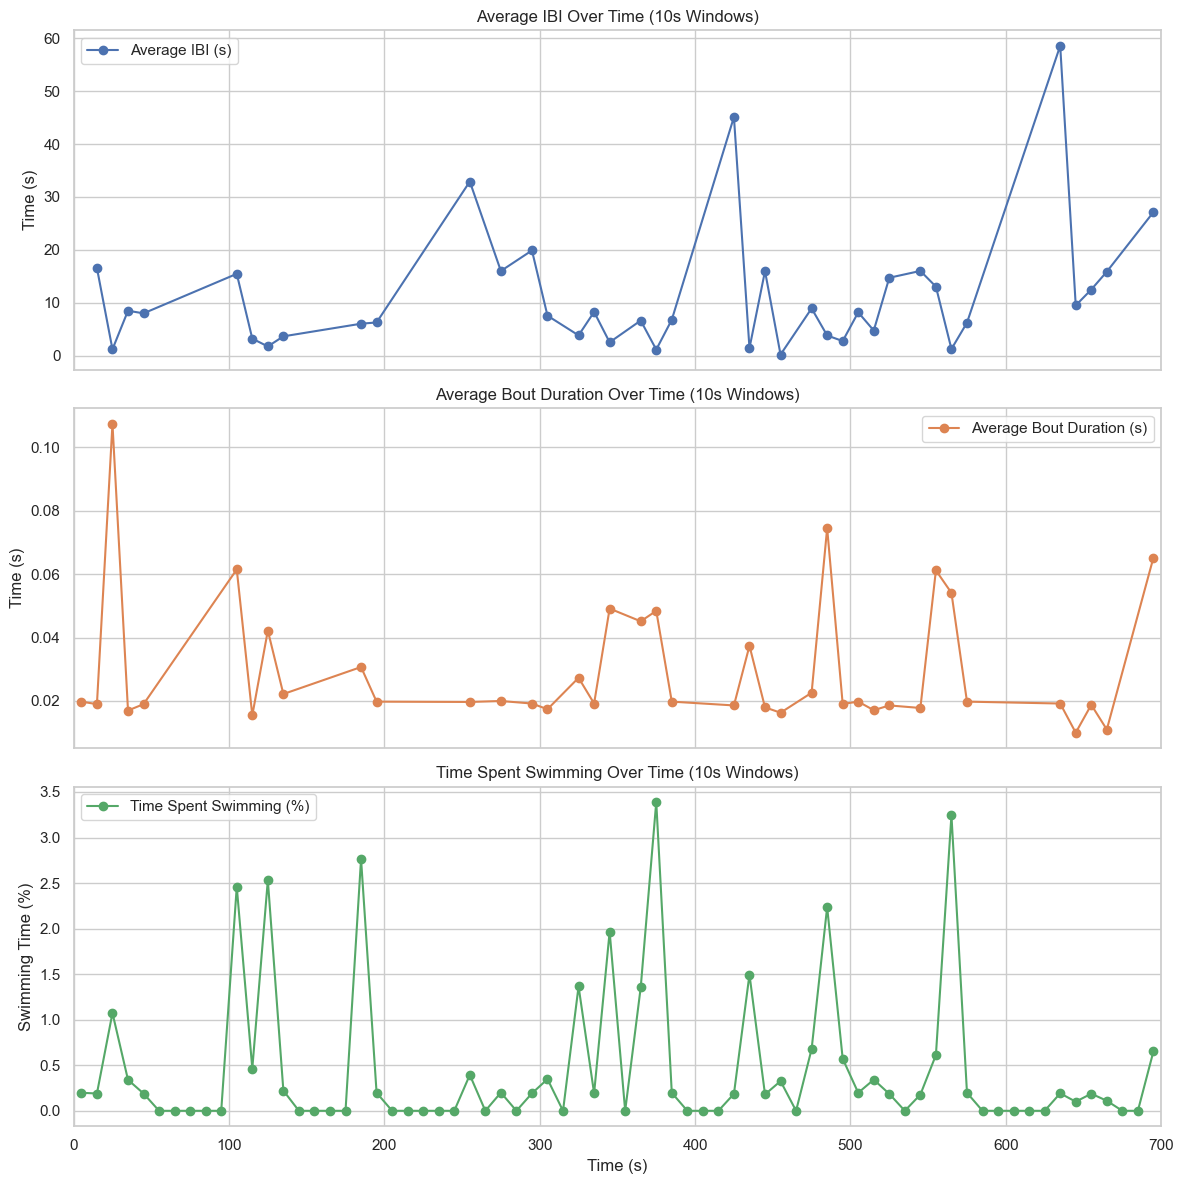

In [112]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create bins spanning 0 to 700 seconds with a 10-second window.
bin_edges = np.arange(0, 700 + 10, 10)  # [0, 10, 20, ..., 700]
bin_centers = bin_edges[:-1] + 5         # e.g., 5, 15, 25, ..., 695

# Initialize lists for each parameter.
avg_IBI_per_bin = []
avg_boutdur_per_bin = []
swim_percentage_per_bin = []

# Loop over each 10-second bin.
for start, end in zip(bin_edges[:-1], bin_edges[1:]):
    # Select bouts that start in the current bin.
    bin_bouts = df_bouts[(df_bouts["BoutStart (s)"] >= start) & 
                          (df_bouts["BoutStart (s)"] < end)]
    
    # For IBI: Exclude NaN values (e.g., the first bout or missing values).
    valid_IBI = bin_bouts["IBI (s)"].dropna()
    # For Bout Duration, exclude any NaN values.
    valid_boutdur = bin_bouts["BoutDuration (s)"].dropna()
    
    # Compute the mean IBI and Bout Duration for the bin.
    avg_IBI = valid_IBI.mean() if len(valid_IBI) > 0 else np.nan
    avg_boutdur = valid_boutdur.mean() if len(valid_boutdur) > 0 else np.nan
    
    avg_IBI_per_bin.append(avg_IBI)
    avg_boutdur_per_bin.append(avg_boutdur)
    
    # Calculate time spent swimming:
    # Sum bout durations within the bin divided by the bin duration (10 s) times 100.
    total_bout_duration = valid_boutdur.sum()  # seconds spent swimming in the bin
    bin_duration = end - start                # should be 10 seconds
    swim_percentage = (total_bout_duration / bin_duration) * 100
    swim_percentage_per_bin.append(swim_percentage)

# Convert lists to NumPy arrays.
bin_centers_arr = np.array(bin_centers)
avg_IBI_arr = np.array(avg_IBI_per_bin)
avg_boutdur_arr = np.array(avg_boutdur_per_bin)
swim_percentage_arr = np.array(swim_percentage_per_bin)

# Create a figure with separate subplots.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot Average IBI in the first subplot.
mask_IBI = ~np.isnan(avg_IBI_arr)
ax1.plot(bin_centers_arr[mask_IBI], avg_IBI_arr[mask_IBI],
         marker='o', linestyle='-', color='C0', label='Average IBI (s)')
ax1.set_ylabel("Time (s)")
ax1.set_title("Average IBI Over Time (10s Windows)")
ax1.grid(True)
ax1.legend()

# Plot Average Bout Duration in the second subplot.
mask_boutdur = ~np.isnan(avg_boutdur_arr)
ax2.plot(bin_centers_arr[mask_boutdur], avg_boutdur_arr[mask_boutdur],
         marker='o', linestyle='-', color='C1', label='Average Bout Duration (s)')
ax2.set_ylabel("Time (s)")
ax2.set_title("Average Bout Duration Over Time (10s Windows)")
ax2.grid(True)
ax2.legend()

# Plot Time Spent Swimming (%) in the third subplot.
ax3.plot(bin_centers_arr, swim_percentage_arr,
         marker='o', linestyle='-', color='C2', label='Time Spent Swimming (%)')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Swimming Time (%)")
ax3.set_title("Time Spent Swimming Over Time (10s Windows)")
ax3.grid(True)
ax3.legend()

plt.xlim(0, 700)
plt.tight_layout()

# Save the entire figure as a single PDF file in the output directory.
pdf_file_path = os.path.join(output_dir, "bout_metrics.pdf")
plt.savefig(pdf_file_path, format="pdf")
print("Figure saved to:", pdf_file_path)

plt.show()


Latency

In [39]:
import os
import glob
import numpy as np
import pandas as pd

def compute_latency_from_bout_seconds(bout_df: pd.DataFrame, stim_times, file_ID, condition="control"):
    bout_df = bout_df.sort_values("BoutStart (s)").reset_index(drop=True)

    latencies = []
    for stim_t in stim_times:
        after = bout_df[bout_df["BoutStart (s)"] > stim_t]
        latencies.append(after.iloc[0]["BoutStart (s)"] - stim_t if not after.empty else np.nan)

    # median IBI before first stim (bouts ending before 183s)
    first_stim = stim_times[0]
    ibis_before = bout_df[(bout_df["BoutEnd (s)"] < first_stim) & bout_df["IBI (s)"].notna()]["IBI (s)"]
    median_ibi_before = ibis_before.median() if not ibis_before.empty else np.nan

    return pd.DataFrame([{
        "file_ID": file_ID,
        "condition": condition,
        "t1": latencies[0] if len(latencies) > 0 else np.nan,
        "t2": latencies[1] if len(latencies) > 1 else np.nan,
        "t3": latencies[2] if len(latencies) > 2 else np.nan,
        "median_ibi_before_stim": median_ibi_before
    }])

# --------- SET PATHS ---------
input_dir = r"C:\Maha\DATA\vnr\analysis\3s_control_2025"
output_dir = r"C:\Maha\DATA\vnr\analysis\3s_control_2025\output_latency"
os.makedirs(output_dir, exist_ok=True)

stim_times_concat = [183.0, 366.0, 549.0]
# -----------------------------

all_rows = []

for csv_path in glob.glob(os.path.join(input_dir, "**", "*bout_parameters*.csv"), recursive=True):
    bout_df = pd.read_csv(csv_path)

    # Identify file_ID
    if "Filename" in bout_df.columns and bout_df["Filename"].notna().any():
        file_ID = str(bout_df["Filename"].iloc[0])
    else:
        file_ID = os.path.splitext(os.path.basename(csv_path))[0].replace("_bout_parameters", "")

    condition = bout_df["Condition"].iloc[0] if "Condition" in bout_df.columns else "control"

    latency_df = compute_latency_from_bout_seconds(
        bout_df=bout_df,
        stim_times=stim_times_concat,
        file_ID=file_ID,
        condition=condition
    )

    # Save per-file
    per_file_out = os.path.join(output_dir, f"{file_ID}_latency_parameters.csv")
    latency_df.to_csv(per_file_out, index=False)

    all_rows.append(latency_df)

# Save combined
if all_rows:
    summary_df = pd.concat(all_rows, ignore_index=True)
    summary_path = os.path.join(output_dir, "all_latency_parameters_control.csv")
    summary_df.to_csv(summary_path, index=False)
    print("Saved:", summary_path)
else:
    print("No bout_parameters CSVs found in:", input_dir)


Saved: C:\Maha\DATA\vnr\analysis\3s_control_2025\output_latency\all_latency_parameters_control.csv


Plotting

In [61]:
import os
import glob
import pandas as pd

# ================= OPSIN: EXPLICIT WHITELIST =================

opsin_files = [
  
    r"C:\Maha\DATA\vnr\analysis\3s_opsin\output_23d13006\bout_parameters.csv",
    r"C:\Maha\DATA\vnr\analysis\3s_opsin\output_23d20003\bout_parameters.csv",
    r"C:\Maha\DATA\vnr\analysis\3s_opsin\output_23d20005\bout_parameters.csv",
    r"C:\Maha\DATA\vnr\analysis\3s_opsin\output_23n30003\bout_parameters.csv",
    r"C:\Maha\DATA\vnr\analysis\3s_opsin\output_23o11003\bout_parameters.csv",
]

# ================= CONTROL: AUTO-LOAD ALL ====================

control_root = r"C:\Maha\DATA\vnr\analysis\3s_control_2025"
control_files = glob.glob(
    os.path.join(control_root, "**", "bout_parameters.csv"),
    recursive=True
)

print(f"Found {len(control_files)} control files")

# ================= OUTPUT ===================================

output_dir = r"C:\Maha\DATA\vnr\analysis\combined"
os.makedirs(output_dir, exist_ok=True)

# ============================================================

dfs = []

def load_and_tag(path, group_label):
    df = pd.read_csv(path)
    df["Group"] = group_label
    df["FishID"] = os.path.basename(os.path.dirname(path))  # e.g. output_23d13001
    df["SourcePath"] = path
    return df

# Load opsin (only selected)
for p in opsin_files:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing opsin file: {p}")
    dfs.append(load_and_tag(p, "3s_opsin"))
    print("Loaded opsin:", p)

# Load ALL control
for p in control_files:
    dfs.append(load_and_tag(p, "3s_control_2025"))
    print("Loaded control:", p)

# Combine
combined_df = pd.concat(dfs, ignore_index=True)

out_csv = os.path.join(output_dir, "VNR_bout_parameters_combined.csv")
combined_df.to_csv(out_csv, index=False)

print("===================================")
print("Saved:", out_csv)
print("Total bouts:", len(combined_df))
print("Opsin files:", len(opsin_files))
print("Control files:", len(control_files))


Found 4 control files
Loaded opsin: C:\Maha\DATA\vnr\analysis\3s_opsin\output_23d13006\bout_parameters.csv
Loaded opsin: C:\Maha\DATA\vnr\analysis\3s_opsin\output_23d20003\bout_parameters.csv
Loaded opsin: C:\Maha\DATA\vnr\analysis\3s_opsin\output_23d20005\bout_parameters.csv
Loaded opsin: C:\Maha\DATA\vnr\analysis\3s_opsin\output_23n30003\bout_parameters.csv
Loaded opsin: C:\Maha\DATA\vnr\analysis\3s_opsin\output_23o11003\bout_parameters.csv
Loaded control: C:\Maha\DATA\vnr\analysis\3s_control_2025\output_25n25006\bout_parameters.csv
Loaded control: C:\Maha\DATA\vnr\analysis\3s_control_2025\output_25n25008\bout_parameters.csv
Loaded control: C:\Maha\DATA\vnr\analysis\3s_control_2025\output_25n25009\bout_parameters.csv
Loaded control: C:\Maha\DATA\vnr\analysis\3s_control_2025\output_25n25010\bout_parameters.csv
Saved: C:\Maha\DATA\vnr\analysis\combined\bout_parameters_3s_opsin_plus_ALL_control.csv
Total bouts: 1598
Opsin files: 5
Control files: 4


Computed metrics stored as pickle file: C:\Maha\DATA\vnr\analysis\df_metrics.pkl


C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_1696\2674347064.py:74: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_metrics, x="BinCenter", y="MeanIBI", hue="Condition", ci=95,
C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_1696\2674347064.py:80: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_metrics, x="BinCenter", y="MeanBoutDuration", hue="Condition", ci=95,
C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_1696\2674347064.py:86: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_metrics, x="BinCenter", y="SwimPercentage", hue="Condition", ci=95,
C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_1696\2674347064.py:92: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df_metrics, x="BinCe

Figure saved to: C:\Maha\DATA\vnr\analysis\bout_metrics_seaborn_lineplot_with_stim.pdf


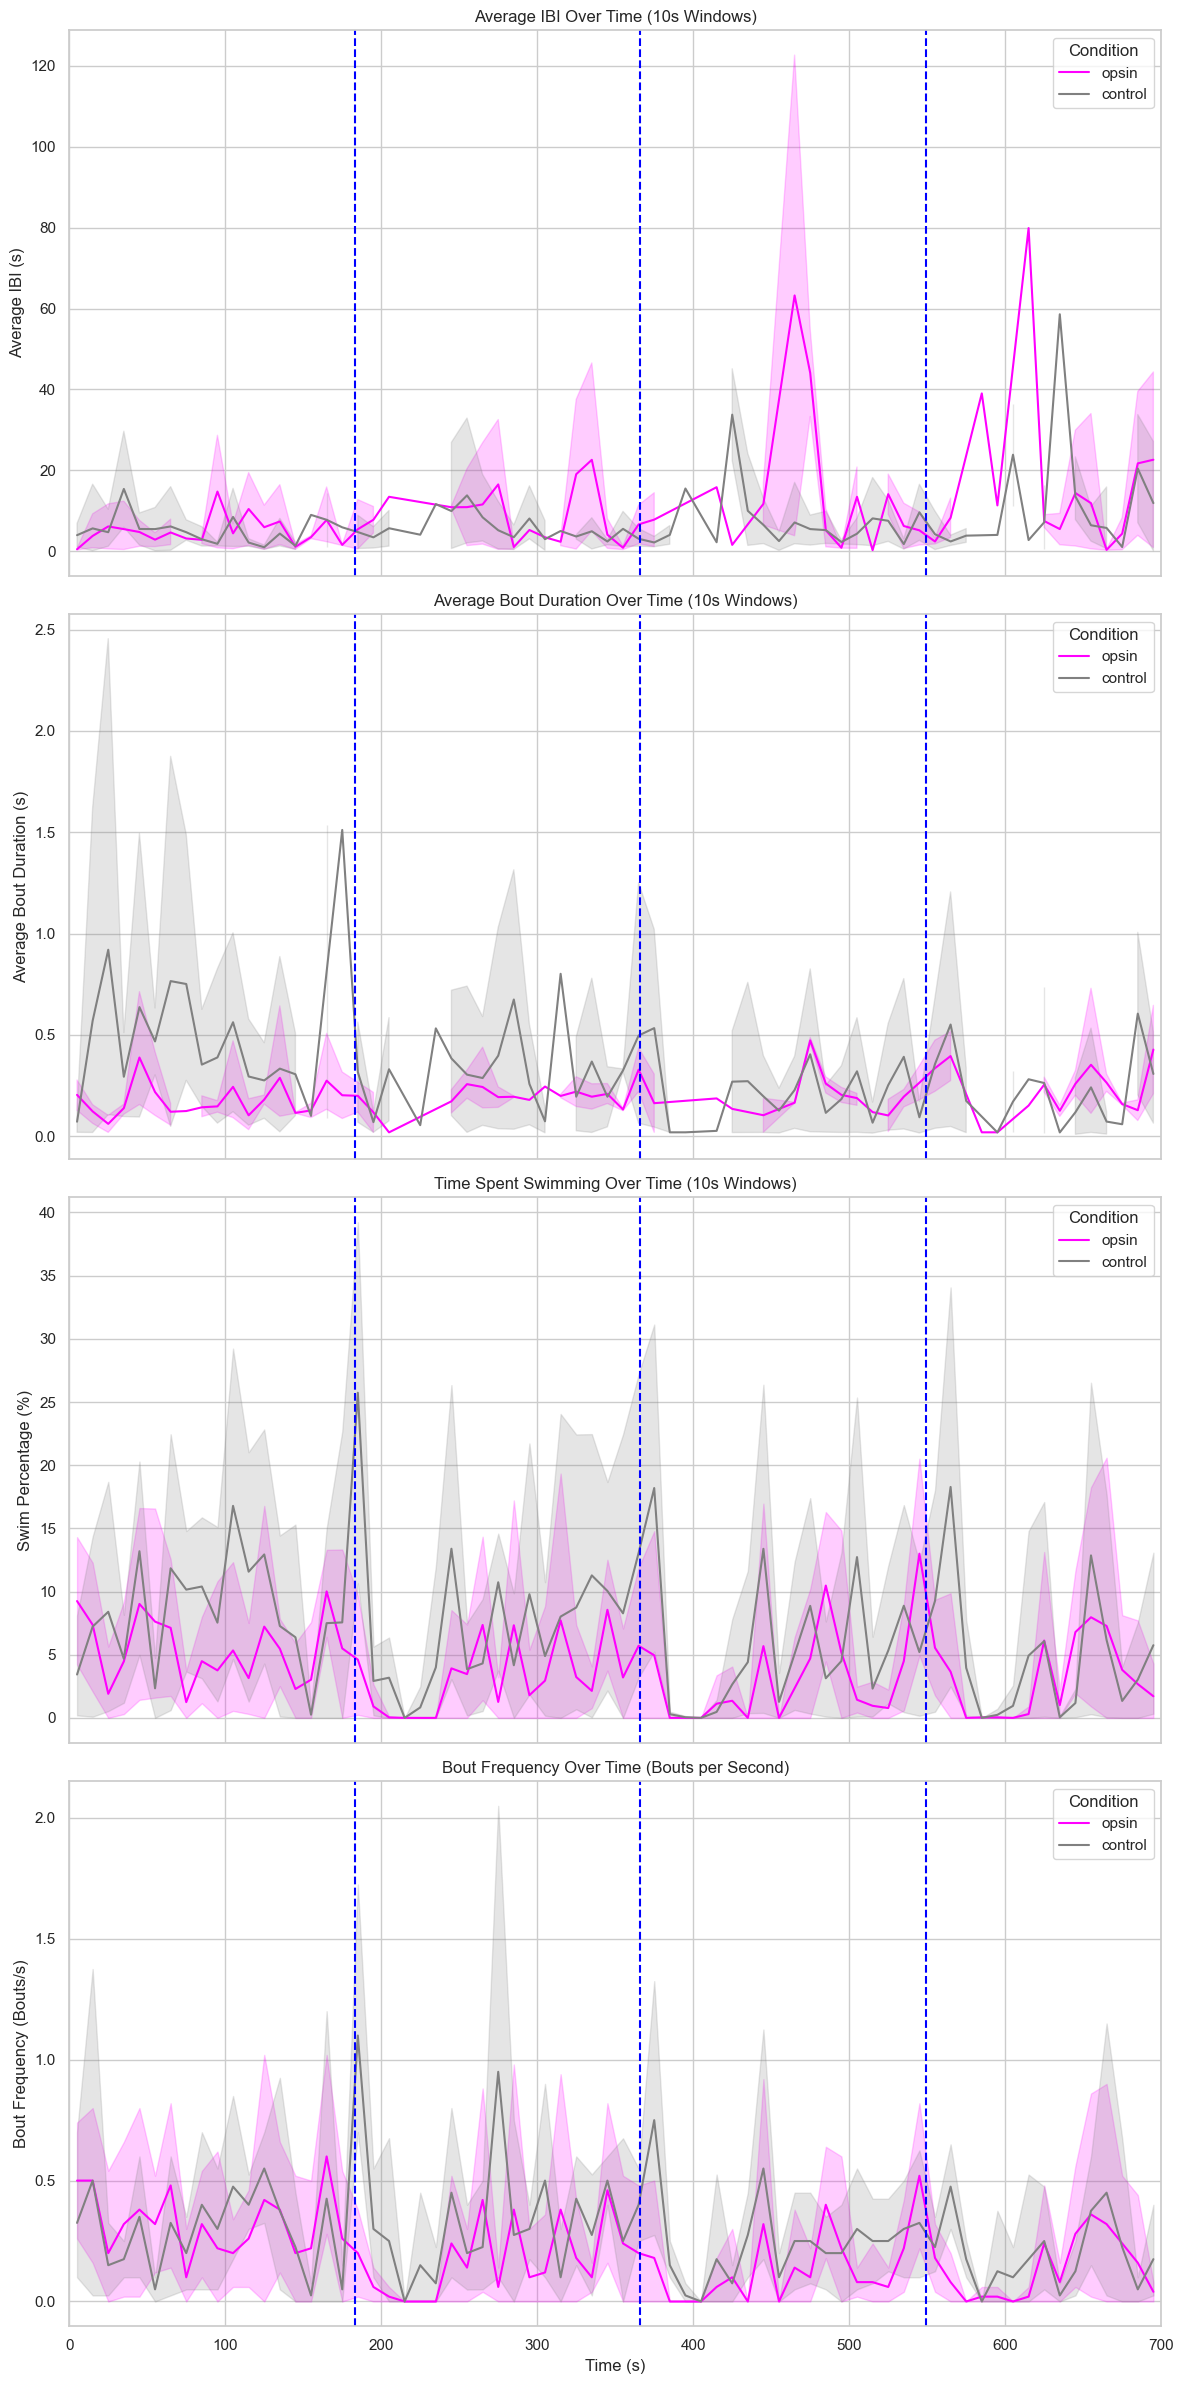

In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 1. Load the combined CSV
# ---------------------------
combined_csv_path = r"C:\Maha\DATA\vnr\analysis\combined\VNR_bout_parameters_combined.csv"
df_bouts = pd.read_csv(combined_csv_path)

# ---------------------------
# 2. Create bins and compute metrics per fish per bin
# ---------------------------
# Create bins spanning 0 to 700 seconds with a 10-second window.
bin_edges = np.arange(0, 700 + 10, 10)  # edges: 0, 10, 20, ... 700
bin_centers = bin_edges[:-1] + 5         # centers: 5, 15, 25, ... 695

# Prepare a list to hold metrics for each fish per bin.
data = []

# Loop over each fish (unique Filename)
for filename, fish_df in df_bouts.groupby("Filename"):
    condition = fish_df["Condition"].iloc[0]  # Each fish should have a single condition.
    # Loop over bins.
    for start, end, center in zip(bin_edges[:-1], bin_edges[1:], bin_centers):
        # Select bouts that start in the current bin.
        bin_bouts = fish_df[(fish_df["BoutStart (s)"] >= start) & 
                            (fish_df["BoutStart (s)"] < end)]
        
        # Compute metrics for the bin.
        mean_IBI = bin_bouts["IBI (s)"].mean() if not bin_bouts.empty else np.nan
        mean_boutdur = bin_bouts["BoutDuration (s)"].mean() if not bin_bouts.empty else np.nan
        
        # Calculate swim percentage: (total bout duration / bin duration) * 100.
        total_bout_duration = bin_bouts["BoutDuration (s)"].sum() if not bin_bouts.empty else 0
        swim_percentage = (total_bout_duration / 10) * 100
        
        # Compute bout frequency as number of bouts per second (count per bin divided by bin duration).
        bout_count = len(bin_bouts)
        bout_frequency = bout_count / (end - start)  # (bouts per second)
        
        data.append({
            "Filename": filename,
            "Condition": condition,
            "BinCenter": center,
            "MeanIBI": mean_IBI,
            "MeanBoutDuration": mean_boutdur,
            "SwimPercentage": swim_percentage,
            "BoutFrequency": bout_frequency
        })

# Create a DataFrame with the computed metrics.
df_metrics = pd.DataFrame(data)

# ---------------------------
# 3. Store computed metrics as a pickle file
# ---------------------------
output_dir = r"C:\Maha\DATA\vnr\analysis"
pickle_file_path = os.path.join(output_dir, "df_metrics.pkl")
df_metrics.to_pickle(pickle_file_path)
print("Computed metrics stored as pickle file:", pickle_file_path)

# ---------------------------
# 4. Plot metrics using Seaborn lineplot with vertical stimulus lines
# ---------------------------
sns.set(style="whitegrid")

# Create subplots for the four metrics.
fig, axs = plt.subplots(4, 1, figsize=(12, 24), sharex=True)

# (a) Plot Average IBI.
sns.lineplot(data=df_metrics, x="BinCenter", y="MeanIBI", hue="Condition", ci=95,
             palette={"control": "grey", "opsin": "magenta"}, ax=axs[0])
axs[0].set_title("Average IBI Over Time (10s Windows)")
axs[0].set_ylabel("Average IBI (s)")

# (b) Plot Average Bout Duration.
sns.lineplot(data=df_metrics, x="BinCenter", y="MeanBoutDuration", hue="Condition", ci=95,
             palette={"control": "grey", "opsin": "magenta"}, ax=axs[1])
axs[1].set_title("Average Bout Duration Over Time (10s Windows)")
axs[1].set_ylabel("Average Bout Duration (s)")

# (c) Plot Time Spent Swimming.
sns.lineplot(data=df_metrics, x="BinCenter", y="SwimPercentage", hue="Condition", ci=95,
             palette={"control": "grey", "opsin": "magenta"}, ax=axs[2])
axs[2].set_title("Time Spent Swimming Over Time (10s Windows)")
axs[2].set_ylabel("Swim Percentage (%)")

# (d) Plot Bout Frequency.
sns.lineplot(data=df_metrics, x="BinCenter", y="BoutFrequency", hue="Condition", ci=95,
             palette={"control": "grey", "opsin": "magenta"}, ax=axs[3])
axs[3].set_title("Bout Frequency Over Time (Bouts per Second)")
axs[3].set_ylabel("Bout Frequency (Bouts/s)")
axs[3].set_xlabel("Time (s)")

# ---------------------------
# 5. Add vertical stimulus lines to each subplot
# ---------------------------
stim_times_concat = [183, 366, 549]  # Adjust this list to match your actual stimulus times
for ax in axs:
    for idx, stim_time in enumerate(stim_times_concat):
        ax.axvline(stim_time, color='blue', linestyle='--', 
                   label='Stimulus' if idx == 0 else "")

plt.xlim(0, 700)
plt.tight_layout()

# ---------------------------
# 6. Save and show the figure
# ---------------------------
pdf_file_path = os.path.join(output_dir, "bout_metrics_seaborn_lineplot_with_stim.pdf")
plt.savefig(pdf_file_path, format="pdf")
print("Figure saved to:", pdf_file_path)
plt.show()


C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_1696\1213224492.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


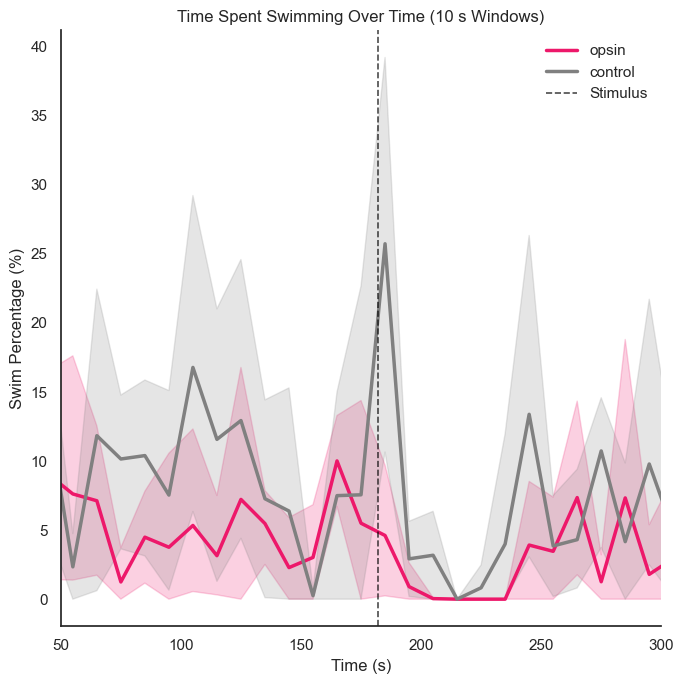

SVG saved to: swim_percentage_timeseries_clean.svg


In [63]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- PARAMETERS ----------------
opsin_color = "#ed186a"
control_color = "grey"
stim_times_concat = [182, 366, 549]
x_min, x_max = 50, 300
# -------------------------------------------

# Disable seaborn background nonsense
sns.set_style("white")

fig_svg, ax_svg = plt.subplots(figsize=(7,7))

sns.lineplot(
    data=df_metrics,
    x="BinCenter",
    y="SwimPercentage",
    hue="Condition",
    ci=95,
    palette={
        "control": control_color,
        "opsin": opsin_color
    },
    linewidth=2.5,
    ax=ax_svg
)

# Stimulus lines (only if inside x-limits)
for i, t in enumerate(stim_times_concat):
    if x_min <= t <= x_max:
        ax_svg.axvline(
            t,
            color="black",
            linestyle="--",
            linewidth=1.2,
            alpha=0.7,
            label="Stimulus" if i == 0 else None
        )

# ---------------- CLEAN AXES ----------------
ax_svg.set_xlim(x_min, x_max)
ax_svg.set_xlabel("Time (s)")
ax_svg.set_ylabel("Swim Percentage (%)")
ax_svg.set_title("Time Spent Swimming Over Time (10 s Windows)")

# Explicitly remove background + grid
ax_svg.set_facecolor("white")
fig_svg.patch.set_facecolor("white")
ax_svg.grid(False)

# Clean spines
for spine in ["top", "right"]:
    ax_svg.spines[spine].set_visible(False)

ax_svg.legend(frameon=False)
fig_svg.tight_layout()

# ---------------- SAVE ----------------
svg_only_path = os.path.join( "swim_percentage_timeseries_clean.svg")
fig_svg.savefig(svg_only_path, format="svg")
plt.show()
plt.close(fig_svg)


print("SVG saved to:", svg_only_path)


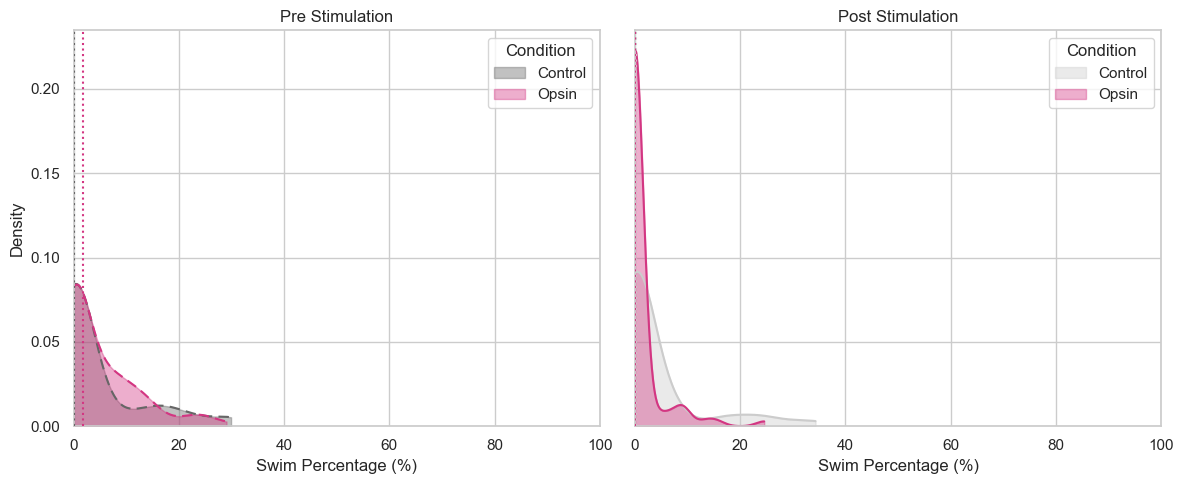

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Output folder
output_dir = r"C:\Maha\DATA\vnr\analysis\swim_svg"
os.makedirs(output_dir, exist_ok=True)

# Styling
sns.set(style="whitegrid")
x_min, x_max = 0, 100
xticks = np.linspace(x_min, x_max, 6)

# Colors and styles
fill_colors = {
    "control": {"Pre": "#666666", "Post": "#cccccc"},
    "opsin":   {"Pre": "#d33682", "Post": "#d33682"}
}
line_styles = {
    "Pre": (0, (5, 3)),   # dashed
    "Post": "solid"
}
alpha = 0.4  # fill transparency

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, window in zip(axes, ["Pre", "Post"]):
    for cond in ["control", "opsin"]:
        subset = df_windows[
            (df_windows["Condition"] == cond) &
            (df_windows["Window"] == window)
        ]

        if subset["SwimPercentage"].dropna().empty:
            continue  # skip if no data

        # Plot KDE to get curve data
        kde = sns.kdeplot(
            data=subset,
            x="SwimPercentage",
            bw_adjust=1,
            cut=0,
            ax=ax,
            color=fill_colors[cond][window],
            linewidth=1.5,
            fill=False
        )

        # Extract line data
        line = kde.get_lines()[-1]
        x_vals, y_vals = line.get_data()

        # Build filled shape
        x_filled = np.concatenate([[x_vals[0]], x_vals, [x_vals[-1]]])
        y_filled = np.concatenate([[0], y_vals, [0]])

        # Fill under KDE curve
        ax.fill_between(
            x_filled, y_filled,
            color=fill_colors[cond][window],
            alpha=alpha,
            label=cond.capitalize()  # label is control / opsin
        )

        # Draw outline
        ax.plot(
            x_vals, y_vals,
            color=fill_colors[cond][window],
            linestyle=line_styles[window],
            linewidth=1.5
        )

        # Draw median line
        median_val = subset["SwimPercentage"].median()
        if x_min <= median_val <= x_max:
            ax.axvline(
                median_val,
                color=fill_colors[cond][window],
                linestyle="dotted",
                linewidth=1.5,
                alpha=1.0,
                zorder=10
            )

        # Remove the internal sns line
        line.remove()

    ax.set_title(f"{window} Stimulation")
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(xticks)
    ax.set_xlabel("Swim Percentage (%)")
    if ax == axes[0]:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")
    ax.legend(title="Condition")

plt.tight_layout()
plt.savefig(os.path.join(r"C:\Maha\DATA\vnr\analysis", "new_pre_post.svg"))
plt.show()

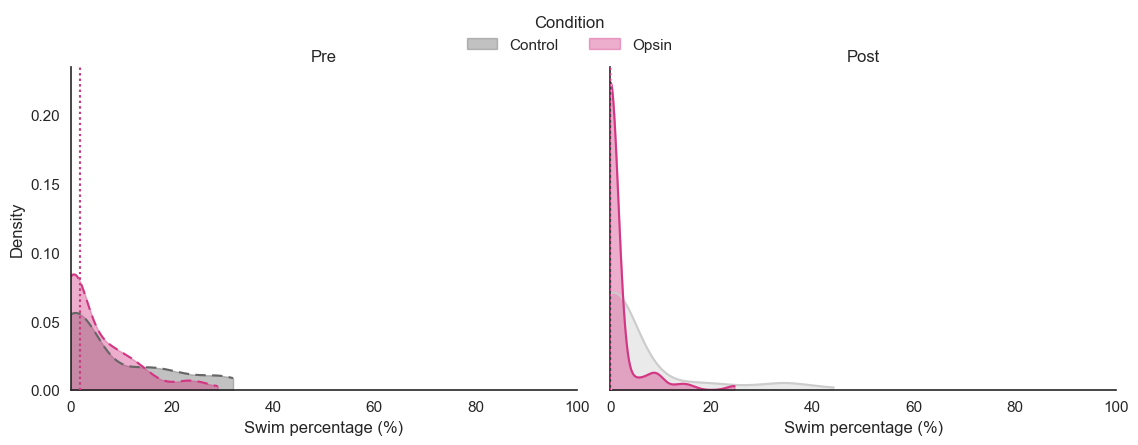

✅ Saved clean SVG:
C:\Maha\DATA\vnr\analysis\swim_svg\new_pre_post_clean_axes.svg


In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Output folder
output_dir = r"C:\Maha\DATA\vnr\analysis\swim_svg"
os.makedirs(output_dir, exist_ok=True)

# ---------- STYLE ----------
sns.set_theme(style="white")  # <-- remove background grid
plt.rcParams.update({
    "axes.linewidth": 1.2,
    "svg.fonttype": "none",   # editable text in Illustrator
    "font.size": 11
})

x_min, x_max = 0, 100
xticks = np.linspace(x_min, x_max, 6)

# Colors and styles
fill_colors = {
    "control": {"Pre": "#666666", "Post": "#cccccc"},
    "opsin":   {"Pre": "#d33682", "Post": "#d33682"}
}
line_styles = {
    "Pre": (0, (5, 3)),   # dashed
    "Post": "solid"
}
alpha = 0.4

# ---------- FIGURE ----------
fig, axes = plt.subplots(
    1, 2,
    figsize=(12, 4.5),   # slightly shorter → less vertical whitespace
    sharey=True
)

for ax, window in zip(axes, ["Pre", "Post"]):
    for cond in ["control", "opsin"]:
        subset = df_windows[
            (df_windows["Condition"] == cond) &
            (df_windows["Window"] == window)
        ]

        if subset["SwimPercentage"].dropna().empty:
            continue

        kde = sns.kdeplot(
            data=subset,
            x="SwimPercentage",
            bw_adjust=1,
            cut=0,
            ax=ax,
            color=fill_colors[cond][window],
            linewidth=1.5,
            fill=False
        )

        # Extract curve
        line = kde.get_lines()[-1]
        x_vals, y_vals = line.get_data()

        # Fill under curve
        ax.fill_between(
            x_vals, y_vals,
            color=fill_colors[cond][window],
            alpha=alpha,
            label=cond.capitalize()
        )

        # Outline
        ax.plot(
            x_vals, y_vals,
            color=fill_colors[cond][window],
            linestyle=line_styles[window],
            linewidth=1.5
        )

        # Median
        median_val = subset["SwimPercentage"].median()
        if x_min <= median_val <= x_max:
            ax.axvline(
                median_val,
                color=fill_colors[cond][window],
                linestyle="dotted",
                linewidth=1.5,
                zorder=10
            )

        line.remove()

    # ---------- AXES ----------
    ax.set_title(f"{window}", pad=4)
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(xticks)
    ax.set_xlabel("Swim percentage (%)")

    # Keep y-axis
    ax.tick_params(axis="both", length=4, width=1)

    # Keep left & bottom spines only (clean frame)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Y label only on left panel
axes[0].set_ylabel("Density")
axes[1].set_ylabel("")

# ---------- LEGEND (single, clean) ----------
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Condition",
    frameon=False,
    loc="upper center",
    ncol=2,
    bbox_to_anchor=(0.5, 1.02)
)

# Tight layout with reduced margins
plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.95])

# ---------- SAVE ----------
out_svg = os.path.join(output_dir, "new_pre_post_clean_axes.svg")
plt.savefig(out_svg, bbox_inches="tight")
plt.show()

print(f"✅ Saved clean SVG:\n{out_svg}")


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# ---------------------------
# 1. Load the combined CSV and compute metrics per fish per bin
# ---------------------------
combined_csv_path = r"C:\Maha\DATA\vnr\analysis\combined\VNR_bout_parameters_combined.csv"
df_bouts = pd.read_csv(combined_csv_path)

# Create bins spanning 0 to 700 seconds with a 10-second window.
bin_edges = np.arange(0, 700 + 10, 10)  # edges: 0, 10, 20, ... 700
bin_centers = bin_edges[:-1] + 5         # centers: 5, 15, 25, ... 695

# Prepare a list to hold metrics for each fish (unique Filename) per bin.
data = []
for filename, fish_df in df_bouts.groupby("Filename"):
    condition = fish_df["Condition"].iloc[0]  # Each fish has one condition.
    for start, end, center in zip(bin_edges[:-1], bin_edges[1:], bin_centers):
        bin_bouts = fish_df[(fish_df["BoutStart (s)"] >= start) & 
                            (fish_df["BoutStart (s)"] < end)]
        mean_IBI = bin_bouts["IBI (s)"].mean() if not bin_bouts.empty else np.nan
        mean_boutdur = bin_bouts["BoutDuration (s)"].mean() if not bin_bouts.empty else np.nan
        total_bout_duration = bin_bouts["BoutDuration (s)"].sum() if not bin_bouts.empty else 0
        swim_percentage = (total_bout_duration / 10) * 100
        bout_count = len(bin_bouts)
        bout_frequency = bout_count / (end - start)  # bouts per second
        
        data.append({
            "Filename": filename,
            "Condition": condition,
            "BinCenter": center,
            "MeanIBI": mean_IBI,
            "MeanBoutDuration": mean_boutdur,
            "SwimPercentage": swim_percentage,
            "BoutFrequency": bout_frequency
        })

df_metrics = pd.DataFrame(data)

# ---------------------------
# 2. Label bins as "Pre" or "Post" relative to stimulus times
# ---------------------------
# Define stimulus times (in seconds)
#stim_times = [183, 366, 549]
stim_times = [183,370,553]
#stim_times = [173, 356, 539]
#stim_times = [  366, 549]


def label_window(bin_center, stim_times):
    for stim in stim_times:
        if (stim - 60) <= bin_center < stim:
            return "Pre"
        elif stim <= bin_center < stim + 60:
            return "Post"
    return None

df_metrics["Window"] = df_metrics["BinCenter"].apply(lambda x: label_window(x, stim_times))
# Keep only rows in Pre or Post windows
df_windows = df_metrics.dropna(subset=["Window"])

# Define the parameters and their nice labels for plotting.
params = ["MeanIBI", "MeanBoutDuration", "SwimPercentage", "BoutFrequency"]
param_labels = {
    "MeanIBI": "Average IBI (s)",
    "MeanBoutDuration": "Bout Duration (s)",
    "SwimPercentage": "Swim Percentage (%)",
    "BoutFrequency": "Bout Frequency (bouts/s)"
}

sns.set(style="whitegrid")

# ---------------------------
# 3. Create PDF file and save the figures
# ---------------------------
output_dir = r"C:\Maha\DATA\vnr\analysis"
pdf_file_path = os.path.join(output_dir, "distribution_plots.pdf")

with PdfPages(pdf_file_path) as pdf:
    
    # Within-Condition Comparisons: For each condition, compare Pre vs Post distributions.
    for cond in ["control", "opsin"]:
        cond_data = df_windows[df_windows["Condition"] == cond]
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        axs = axs.flatten()
        for i, param in enumerate(params):
            ax = axs[i]
            sns.histplot(data=cond_data, x=param, hue="Window", kde=True, 
                         palette={"Pre": "lightblue", "Post": "orange"},
                         ax=ax, element="step", stat="density", common_norm=False)
            ax.set_title(f"{param_labels[param]} (Condition: {cond.capitalize()})")
        fig.suptitle(f"Within-Condition Distribution (Pre vs Post) for {cond.capitalize()} Fish", fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)
    
    # Across-Condition Comparisons: For each window, compare distributions between control and opsin.
    for window in ["Pre", "Post"]:
        window_data = df_windows[df_windows["Window"] == window]
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        axs = axs.flatten()
        for i, param in enumerate(params):
            ax = axs[i]
            sns.histplot(data=window_data, x=param, hue="Condition", kde=True,
                         palette={"control": "grey", "opsin": "magenta"},
                         ax=ax, element="step", stat="density", common_norm=False)
            ax.set_title(f"{param_labels[param]} (Window: {window})")
        fig.suptitle(f"Across-Condition Distribution for {window} Window", fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)

print("Figures saved to PDF file:", pdf_file_path)

pickle_file_path = os.path.join(output_dir, "df_metrics.pkl")
csv_file_path = os.path.join(output_dir, "df_metrics.csv")

df_metrics.to_pickle(pickle_file_path)
df_metrics.to_csv(csv_file_path, index=False)

print("Computed metrics stored as pickle file:", pickle_file_path)
print("Computed metrics stored as CSV file:", csv_file_path)

Figures saved to PDF file: C:\Maha\DATA\vnr\analysis\distribution_plots.pdf
Computed metrics stored as pickle file: C:\Maha\DATA\vnr\analysis\df_metrics.pkl
Computed metrics stored as CSV file: C:\Maha\DATA\vnr\analysis\df_metrics.csv


               Comparison                 Parameter  Statistic       p-value
0     Control Pre vs Post           Average IBI (s)   0.150706  6.382125e-01
1     Control Pre vs Post         Bout Duration (s)   0.217164  2.165076e-01
2     Control Pre vs Post       Swim Percentage (%)   0.208333  8.778698e-02
3     Control Pre vs Post  Bout Frequency (bouts/s)   0.180556  1.918086e-01
4       Opsin Pre vs Post           Average IBI (s)   0.257353  3.131922e-01
5       Opsin Pre vs Post         Bout Duration (s)   0.294118  1.798276e-01
6       Opsin Pre vs Post       Swim Percentage (%)   0.400000  8.061895e-07
7       Opsin Pre vs Post  Bout Frequency (bouts/s)   0.344444  3.932772e-05
8    Pre control vs opsin           Average IBI (s)   0.169643  4.373979e-01
9    Pre control vs opsin         Bout Duration (s)   0.365646  1.600185e-03
10   Pre control vs opsin       Swim Percentage (%)   0.191667  9.326125e-02
11   Pre control vs opsin  Bout Frequency (bouts/s)   0.147222  3.206447e-01

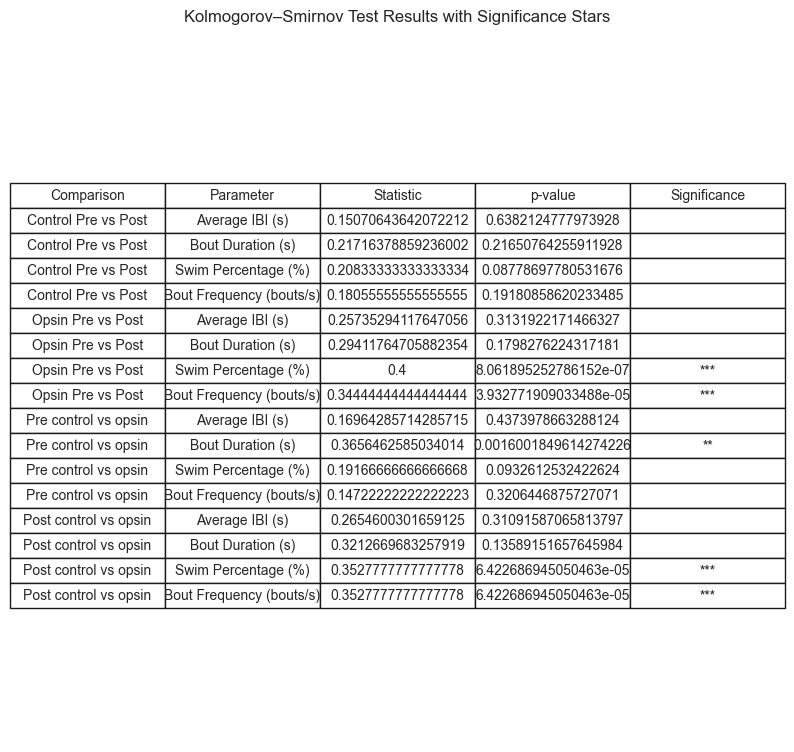

In [65]:
import os
import pandas as pd
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# (Assuming df_windows, params, param_labels, and output_dir are already defined.)
# For example:
# df_windows = <your preprocessed dataframe with 'Condition', 'Window', etc.>
# params = ["MeanIBI", "MeanBoutDuration", "SwimPercentage", "BoutFrequency"]
# param_labels = {"MeanIBI": "Average IBI (s)",
#                 "MeanBoutDuration": "Bout Duration (s)",
#                 "SwimPercentage": "Swim Percentage (%)",
#                 "BoutFrequency": "Bout Frequency (bouts/s)"}
# output_dir = r"C:\Maha\DATA\vnr\analysis"

# ---------------------------
# 1. Perform Kolmogorov–Smirnov tests and store results.
# ---------------------------
ks_results = []

# Within-Condition Comparisons: Compare Pre vs Post for each condition.
for cond in ["control", "opsin"]:
    subset = df_windows[df_windows["Condition"] == cond]
    for param in params:
        # Extract the data for Pre and Post windows.
        group_pre = subset[subset["Window"] == "Pre"][param].dropna()
        group_post = subset[subset["Window"] == "Post"][param].dropna()
        
        if len(group_pre) < 2 or len(group_post) < 2:
            continue
        
        result = ks_2samp(group_pre, group_post)
        ks_results.append({
            "Comparison": f"{cond.capitalize()} Pre vs Post",
            "Parameter": param_labels[param],
            "Statistic": result.statistic,
            "p-value": result.pvalue
        })

# Across-Condition Comparisons: For each window, compare control vs opsin.
for window in ["Pre", "Post"]:
    subset = df_windows[df_windows["Window"] == window]
    for param in params:
        group_control = subset[subset["Condition"] == "control"][param].dropna()
        group_opsin = subset[subset["Condition"] == "opsin"][param].dropna()
        
        if len(group_control) < 2 or len(group_opsin) < 2:
            continue
        
        result = ks_2samp(group_control, group_opsin)
        ks_results.append({
            "Comparison": f"{window} control vs opsin",
            "Parameter": param_labels[param],
            "Statistic": result.statistic,
            "p-value": result.pvalue
        })

ks_results_df = pd.DataFrame(ks_results)
print(ks_results_df)

# ---------------------------
# 2. Export KS test results as CSV.
# ---------------------------
output_csv_path = os.path.join(output_dir, "ks_results.csv")
ks_results_df.to_csv(output_csv_path, index=False)
print("K–S test results exported to:", output_csv_path)

# ---------------------------
# 3. Add significance stars based on p-values.
# ---------------------------
def get_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

ks_results_df["Significance"] = ks_results_df["p-value"].apply(get_stars)

# ---------------------------
# 4. Plot a table with the KS test results including significance stars.
# ---------------------------
fig, ax = plt.subplots(figsize=(10, len(ks_results_df)*0.5 + 1))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=ks_results_df.values, 
                 colLabels=ks_results_df.columns, 
                 cellLoc='center', 
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.title("Kolmogorov–Smirnov Test Results with Significance Stars", pad=20)

# Save the table as a PDF.
table_pdf_path = os.path.join(output_dir, "ks_results_table.pdf")
fig.savefig(table_pdf_path, bbox_inches='tight')
print("KS test results table saved to:", table_pdf_path)

plt.show()


--- Processing: control | C:\Maha\DATA\vnr\analysis\3s_control_2025 ---
✔ Saved: C:\Maha\DATA\vnr\analysis\3s_control_2025\output_25n25006\latency_parameters_from_csv.csv
✔ Saved: C:\Maha\DATA\vnr\analysis\3s_control_2025\output_25n25008\latency_parameters_from_csv.csv
✔ Saved: C:\Maha\DATA\vnr\analysis\3s_control_2025\output_25n25009\latency_parameters_from_csv.csv
✔ Saved: C:\Maha\DATA\vnr\analysis\3s_control_2025\output_25n25010\latency_parameters_from_csv.csv

--- Processing: opsin | C:\Maha\DATA\vnr\analysis\3s_opsin ---
✔ Saved: C:\Maha\DATA\vnr\analysis\3s_opsin\output_23d13006\latency_parameters_from_csv.csv
✔ Saved: C:\Maha\DATA\vnr\analysis\3s_opsin\output_23d20003\latency_parameters_from_csv.csv
✔ Saved: C:\Maha\DATA\vnr\analysis\3s_opsin\output_23d20005\latency_parameters_from_csv.csv
✔ Saved: C:\Maha\DATA\vnr\analysis\3s_opsin\output_23n30003\latency_parameters_from_csv.csv
✔ Saved: C:\Maha\DATA\vnr\analysis\3s_opsin\output_23o11003\latency_parameters_from_csv.csv

✅ Save

C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_1696\2997160089.py:170: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


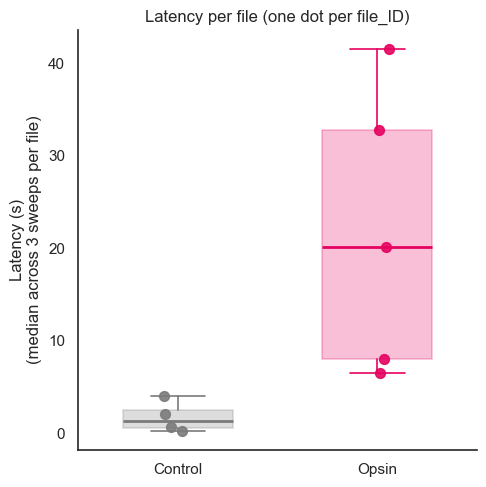

✅ Saved boxplots:
- C:\Maha\DATA\vnr\analysis\latency_summary\latency_boxplot_one_dot_per_file.svg
- C:\Maha\DATA\vnr\analysis\latency_summary\latency_boxplot_one_dot_per_file.pdf

================= GROUP COMPARISON =================

DEBUG: n_control = 4, n_opsin = 5

CONTROL
mean ± SEM = 1.776 ± 0.843
median     = 1.388

OPSIN
mean ± SEM = 21.794 ± 6.830
median     = 20.129

--- Mann–Whitney U (one-sided: opsin > control) ---
U = 20.000
p = 0.007937

--- Welch t-test (two-sided) ---
t = 2.909
p = 0.042168

================= DONE =================



In [82]:
# ============================================================
# latency_process_boxplot_stats.py
# - Process BOTH: 3s_control_2025 and 3s_opsin
# - Compute latency t1/t2/t3 per file_ID (output_*)
# - Collapse to ONE value per file_ID: median_latency_all_trials (median of t1,t2,t3)
# - Save per-folder latency_parameters_from_csv.csv
# - Make colored boxplot (grey control, magenta opsin) with ONE DOT per file_ID
# - Run stats comparing groups (MWU one-sided + Welch t-test) and print mean±SEM + median
# ============================================================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind

# -----------------------------
# CONFIGURATION
# -----------------------------
ROOTS = [
    (r"C:\Maha\DATA\vnr\analysis\3s_control_2025", "control"),
    (r"C:\Maha\DATA\vnr\analysis\3s_opsin", "opsin"),  # <-- edit if needed
]

stim_time = 186          # stim time within each sweep (s)
sweep_duration = 240     # seconds
num_sweeps = 3

# Group output
OUT_DIR = r"C:\Maha\DATA\vnr\analysis\latency_summary"
OUT_SUMMARY_CSV = os.path.join(OUT_DIR, "latency_summary_one_dot_per_file.csv")
OUT_BOX_SVG = os.path.join(OUT_DIR, "latency_boxplot_one_dot_per_file.svg")
OUT_BOX_PDF = os.path.join(OUT_DIR, "latency_boxplot_one_dot_per_file.pdf")

# Colors
COLOR_MAP = {
    "control": "#7a7a7a",  # grey
    "opsin":   "#e60260",  # magenta
}

# Optional: exclude specific output folders by exact name (foldername like "output_F3_t2...")
EXCLUDE_OUTPUT_FOLDERS = set()


# -----------------------------
# HELPERS
# -----------------------------
def compute_latencies_and_ibi(df_bouts: pd.DataFrame,
                              stim_time: float,
                              sweep_duration: float,
                              num_sweeps: int):
    """Return (latencies list [t1,t2,t3], median_latency_across_trials, median_ibi_before_first_stim)."""
    stim_times = [sweep * sweep_duration + stim_time for sweep in range(num_sweeps)]

    latencies = []
    for stim in stim_times:
        bouts_after = df_bouts[df_bouts["BoutStart (s)"] > stim]
        if not bouts_after.empty:
            latency = float(bouts_after.iloc[0]["BoutStart (s)"] - stim)
        else:
            latency = np.nan
        latencies.append(latency)

    median_latency = float(np.nanmedian(latencies)) if np.any(~np.isnan(latencies)) else np.nan

    if "IBI (s)" in df_bouts.columns:
        ibis_before = df_bouts[
            (df_bouts["BoutEnd (s)"] < stim_times[0]) &
            (df_bouts["IBI (s)"].notna())
        ]
        median_ibi = float(ibis_before["IBI (s)"].median()) if not ibis_before.empty else np.nan
    else:
        median_ibi = np.nan

    return latencies, median_latency, median_ibi


def process_root(root_dir: str, condition: str):
    """Process all output_* folders in root_dir. Save per-folder CSV and return per-file summary rows."""
    rows = []

    if not os.path.isdir(root_dir):
        print(f"⚠️ Root not found, skipping: {root_dir}")
        return rows

    for foldername in sorted(os.listdir(root_dir)):
        if not foldername.startswith("output_"):
            continue
        if foldername in EXCLUDE_OUTPUT_FOLDERS:
            print(f"⚠️ Excluding folder: {foldername}")
            continue

        folder_path = os.path.join(root_dir, foldername)
        bout_csv_path = os.path.join(folder_path, "bout_parameters.csv")
        if not os.path.isfile(bout_csv_path):
            continue

        try:
            df_bouts = pd.read_csv(bout_csv_path)

            # Required columns
            if "BoutStart (s)" not in df_bouts.columns or "BoutEnd (s)" not in df_bouts.columns:
                print(f"⚠️ Skipped {foldername}: Missing 'BoutStart (s)' or 'BoutEnd (s)'.")
                continue

            # Coerce numeric
            df_bouts["BoutStart (s)"] = pd.to_numeric(df_bouts["BoutStart (s)"], errors="coerce")
            df_bouts["BoutEnd (s)"] = pd.to_numeric(df_bouts["BoutEnd (s)"], errors="coerce")
            if "IBI (s)" in df_bouts.columns:
                df_bouts["IBI (s)"] = pd.to_numeric(df_bouts["IBI (s)"], errors="coerce")

            df_bouts = df_bouts.dropna(subset=["BoutStart (s)", "BoutEnd (s)"]).copy()
            df_bouts = df_bouts.sort_values("BoutStart (s)")

            latencies, med_latency, med_ibi = compute_latencies_and_ibi(
                df_bouts,
                stim_time=stim_time,
                sweep_duration=sweep_duration,
                num_sweeps=num_sweeps
            )

            file_ID = foldername

            latency_df = pd.DataFrame({
                "file_ID": [file_ID],
                "condition": [condition],
                "t1": [latencies[0] if len(latencies) > 0 else np.nan],
                "t2": [latencies[1] if len(latencies) > 1 else np.nan],
                "t3": [latencies[2] if len(latencies) > 2 else np.nan],
                "median_latency_all_trials": [med_latency],   # <-- ONE DOT PER FILE_ID
                "median_ibi_before_stim": [med_ibi],
                "root_dir": [root_dir],
            })

            # Save per-folder output (like your original)
            out_path = os.path.join(folder_path, "latency_parameters_from_csv.csv")
            latency_df.to_csv(out_path, index=False)
            print(f"✔ Saved: {out_path}")

            rows.append(latency_df.iloc[0].to_dict())

        except Exception as e:
            print(f"❌ Error processing {foldername} ({condition}): {e}")

    return rows


def make_colored_boxplot(df_summary: pd.DataFrame, out_svg: str, out_pdf: str):
    """Boxplot of per-file medians (one dot per file_ID), colored by condition."""
    os.makedirs(os.path.dirname(out_svg), exist_ok=True)

    dfp = df_summary.dropna(subset=["median_latency_all_trials"]).copy()
    order = [c for c in ["control", "opsin"] if c in dfp["condition"].unique()]
    if not order:
        print("⚠️ No data for plotting.")
        return

    data = [dfp.loc[dfp["condition"] == c, "median_latency_all_trials"].to_numpy()
            for c in order]

    plt.rcParams.update({
        "svg.fonttype": "none",  # editable text in Illustrator
        "axes.linewidth": 1.2,
        "font.size": 11
    })

    fig, ax = plt.subplots(figsize=(5, 5))

    bp = ax.boxplot(
        data,
        labels=[c.capitalize() for c in order],
        showfliers=False,
        widths=0.55,
        patch_artist=True,
        medianprops=dict(linewidth=2),
        boxprops=dict(linewidth=1.2),
        whiskerprops=dict(linewidth=1.2),
        capprops=dict(linewidth=1.2),
    )

    # Color each box and its elements to match condition
    for i, cond in enumerate(order):
        color = COLOR_MAP.get(cond, "black")

        bp["boxes"][i].set_facecolor(color)
        bp["boxes"][i].set_alpha(0.25)
        bp["boxes"][i].set_edgecolor(color)

        bp["medians"][i].set_color(color)

        bp["whiskers"][2*i].set_color(color)
        bp["whiskers"][2*i + 1].set_color(color)
        bp["caps"][2*i].set_color(color)
        bp["caps"][2*i + 1].set_color(color)

    # One dot per file_ID (median across trials)
    rng = np.random.default_rng(0)
    for i, cond in enumerate(order, start=1):
        y = dfp.loc[dfp["condition"] == cond, "median_latency_all_trials"].to_numpy()
        x = i + rng.uniform(-0.07, 0.07, size=len(y))
        ax.scatter(x, y, s=50, color=COLOR_MAP.get(cond, "black"), alpha=0.9, zorder=3)

    ax.set_ylabel("Latency (s)\n(median across 3 sweeps per file)")
    ax.set_title("Latency per file (one dot per file_ID)")

    # Clean axes (Adobe-friendly)
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.tight_layout()
    fig.savefig(out_svg, bbox_inches="tight")
    fig.savefig(out_pdf, bbox_inches="tight")
    plt.show()

    print(f"✅ Saved boxplots:\n- {out_svg}\n- {out_pdf}")


def compare_groups_stats(df_summary: pd.DataFrame):
    """Compare control vs opsin using one value per file_ID: median_latency_all_trials."""
    print("\n================= GROUP COMPARISON =================")

    if "median_latency_all_trials" not in df_summary.columns:
        raise ValueError("❌ df_summary missing 'median_latency_all_trials' column")

    dfp = df_summary.dropna(subset=["median_latency_all_trials"]).copy()

    ctrl = dfp[dfp["condition"] == "control"]["median_latency_all_trials"].to_numpy()
    ops  = dfp[dfp["condition"] == "opsin"]["median_latency_all_trials"].to_numpy()

    print(f"\nDEBUG: n_control = {len(ctrl)}, n_opsin = {len(ops)}")

    if len(ctrl) < 2 or len(ops) < 2:
        print("❌ Not enough files per group for stats")
        return

    def mean_sem(x):
        return np.mean(x), np.std(x, ddof=1) / np.sqrt(len(x))

    ctrl_mean, ctrl_sem = mean_sem(ctrl)
    ops_mean, ops_sem   = mean_sem(ops)

    print("\nCONTROL")
    print(f"mean ± SEM = {ctrl_mean:.3f} ± {ctrl_sem:.3f}")
    print(f"median     = {np.median(ctrl):.3f}")

    print("\nOPSIN")
    print(f"mean ± SEM = {ops_mean:.3f} ± {ops_sem:.3f}")
    print(f"median     = {np.median(ops):.3f}")

    # Primary: Mann–Whitney U (one-sided)
    # H1: opsin > control (latency increased in opsin)
    u_stat, p_mwu = mannwhitneyu(ops, ctrl, alternative="greater")
    print("\n--- Mann–Whitney U (one-sided: opsin > control) ---")
    print(f"U = {u_stat:.3f}")
    print(f"p = {p_mwu:.6f}")

    # Secondary: Welch t-test (two-sided)
    t_stat, p_t = ttest_ind(ops, ctrl, equal_var=False)
    print("\n--- Welch t-test (two-sided) ---")
    print(f"t = {t_stat:.3f}")
    print(f"p = {p_t:.6f}")

    print("\n================= DONE =================\n")


# -----------------------------
# MAIN
# -----------------------------
def main():
    all_rows = []

    for root_dir, cond in ROOTS:
        print(f"\n--- Processing: {cond} | {root_dir} ---")
        all_rows.extend(process_root(root_dir, cond))

    if not all_rows:
        print("⚠️ No output_* folders processed. Check paths.")
        return

    os.makedirs(OUT_DIR, exist_ok=True)
    df_summary = pd.DataFrame(all_rows)

    # Save summary (one row per file_ID)
    df_summary.to_csv(OUT_SUMMARY_CSV, index=False)
    print(f"\n✅ Saved summary CSV:\n- {OUT_SUMMARY_CSV}")

    # Plot + stats
    make_colored_boxplot(df_summary, OUT_BOX_SVG, OUT_BOX_PDF)
    compare_groups_stats(df_summary)


if __name__ == "__main__":
    main()


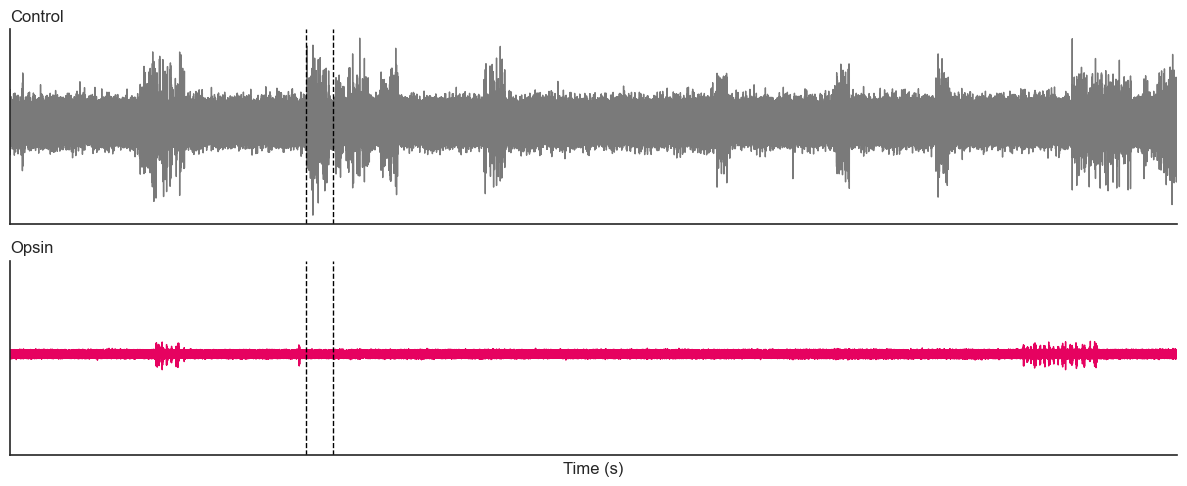

✅ Saved rescaled stacked plot: C:\Maha\DATA\vnr\VNR_control_opsin_stacked_rescaled.svg
DEBUG y-limits after scaling: (np.float32(-0.64719695), np.float32(0.59510344))


In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pyabf

# -------------------------------------------------------------------------
# FILE PATHS
# -------------------------------------------------------------------------
control_abf_path = r'C:\Maha\DATA\vnr\analysis\3s_control_2025\25n25010.abf'
opsin_abf_path   = r'C:\Maha\DATA\vnr\analysis\3s_opsin\23d13006.abf'

# -------------------------------------------------------------------------
# LOAD ABF FILES
# -------------------------------------------------------------------------
abf_ctrl = pyabf.ABF(control_abf_path)
abf_ops  = pyabf.ABF(opsin_abf_path)

# -------------------------------------------------------------------------
# CONCATENATE SWEEPS
# -------------------------------------------------------------------------
def concat_sweeps(abf):
    y = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])
    sr = abf.dataRate
    t = np.arange(len(y)) / sr
    return t, y

t_ctrl, vr_ctrl = concat_sweeps(abf_ctrl)
t_ops,  vr_ops  = concat_sweeps(abf_ops)

# -------------------------------------------------------------------------
# 🔧 FIX: RESCALE CONTROL TRACE
# -------------------------------------------------------------------------
vr_ctrl = vr_ctrl / 100.0   # <-- critical correction

# -------------------------------------------------------------------------
# STIMULUS TIMES
# -------------------------------------------------------------------------
stim_times = [183, 366, 549]
stim_dur = 3  # seconds

# -------------------------------------------------------------------------
# PLOT WINDOW
# -------------------------------------------------------------------------
x0, x1 = 150, 280

# Shared y-limits (now meaningful)
ctrl_win = vr_ctrl[(t_ctrl >= x0) & (t_ctrl <= x1)]
ops_win  = vr_ops[(t_ops  >= x0) & (t_ops  <= x1)]

y_min = min(ctrl_win.min(), ops_win.min())
y_max = max(ctrl_win.max(), ops_win.max())

pad = 0.05 * (y_max - y_min)
y_lim = (y_min - pad, y_max + pad)

# -------------------------------------------------------------------------
# PLOT (stacked, same y-scale, minimal axes)
# -------------------------------------------------------------------------
plt.rcParams.update({
    "svg.fonttype": "none",
    "axes.linewidth": 1.2,
    "font.size": 11
})

fig, axs = plt.subplots(
    2, 1,
    figsize=(12, 5),
    sharex=True,
    sharey=True
)

# ---------- CONTROL ----------
axs[0].plot(t_ctrl, vr_ctrl, color="#7a7a7a", linewidth=1)
axs[0].set_title("Control", loc="left")

# ---------- OPSIN ----------
axs[1].plot(t_ops, vr_ops, color="#e60260", linewidth=1)
axs[1].set_title("Opsin", loc="left")

# ---------- STIM LINES + FORMATTING ----------
for ax in axs:
    for stim in stim_times:
        ax.axvline(stim, color="black", linestyle="--", linewidth=1)
        ax.axvline(stim + stim_dur, color="black", linestyle="--", linewidth=1)

    ax.set_xlim(x0, x1)
    ax.set_ylim(*y_lim)

    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # keep spines for scale bars, remove clutter
    ax.tick_params(left=False, labelleft=False,
                   bottom=False, labelbottom=False)

axs[1].set_xlabel("Time (s)")

plt.tight_layout()

# -------------------------------------------------------------------------
# SAVE
# -------------------------------------------------------------------------
out_path = r'C:\Maha\DATA\vnr\VNR_control_opsin_stacked_rescaled.svg'
plt.savefig(out_path, format="svg", dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ Saved rescaled stacked plot: {out_path}")
print(f"DEBUG y-limits after scaling: {y_lim}")


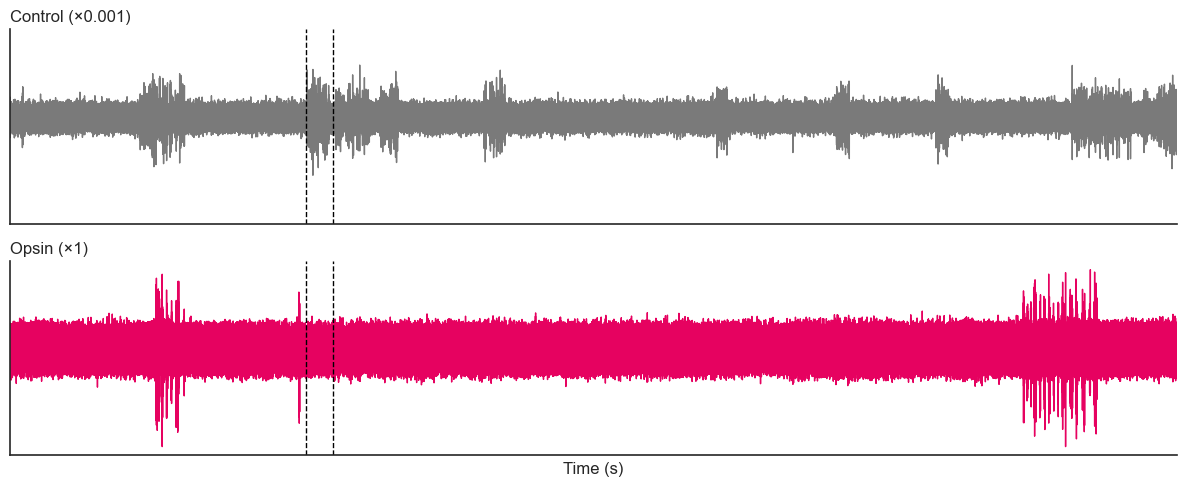

✅ Saved: C:\Maha\DATA\vnr\VNR_control_opsin_stacked_scaled_control.svg
DEBUG window ranges (after scaling):
  control min/max: -0.05907287821173668 0.0538635291159153
  opsin   min/max: -0.10000000149011612 0.0813751220703125
DEBUG y_lim: (np.float32(-0.10906876), np.float32(0.09044388))


In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pyabf

# -------------------------------------------------------------------------
# FILE PATHS
# -------------------------------------------------------------------------
control_abf_path = r'C:\Maha\DATA\vnr\analysis\3s_control_2025\25n25010.abf'
opsin_abf_path   = r'C:\Maha\DATA\vnr\analysis\3s_opsin\23d13006.abf'


# -------------------------------------------------------------------------
# USER SCALING (no resampling)
# -------------------------------------------------------------------------
CONTROL_SCALE = 1e-3   # divide by 1000 to fix 50 -> 0.05
OPSIN_SCALE   = 1.0    # leave as-is

# -------------------------------------------------------------------------
# LOAD ABF FILES
# -------------------------------------------------------------------------
abf_ctrl = pyabf.ABF(control_abf_path)
abf_ops  = pyabf.ABF(opsin_abf_path)

# -------------------------------------------------------------------------
# CONCATENATE SWEEPS
# -------------------------------------------------------------------------
def concat_sweeps(abf):
    y = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])
    sr = abf.dataRate
    t = np.arange(len(y)) / sr
    return t, y

t_ctrl, vr_ctrl = concat_sweeps(abf_ctrl)
t_ops,  vr_ops  = concat_sweeps(abf_ops)

# Apply scaling
vr_ctrl_plot = vr_ctrl * CONTROL_SCALE
vr_ops_plot  = vr_ops  * OPSIN_SCALE

# -------------------------------------------------------------------------
# STIMULUS TIMES
# -------------------------------------------------------------------------
stim_times = [183, 366, 549]
stim_dur = 3

# -------------------------------------------------------------------------
# PLOT WINDOW
# -------------------------------------------------------------------------
x0, x1 = 150, 280

# Shared y-lims from visible window
ctrl_win = vr_ctrl_plot[(t_ctrl >= x0) & (t_ctrl <= x1)]
ops_win  = vr_ops_plot[(t_ops  >= x0) & (t_ops  <= x1)]

y_min = min(ctrl_win.min(), ops_win.min())
y_max = max(ctrl_win.max(), ops_win.max())
pad = 0.05 * (y_max - y_min) if y_max > y_min else 1.0
y_lim = (y_min - pad, y_max + pad)

# -------------------------------------------------------------------------
# PLOT (stacked, same y-scale, minimal axes, scale-bar friendly)
# -------------------------------------------------------------------------
plt.rcParams.update({"svg.fonttype": "none", "axes.linewidth": 1.2, "font.size": 11})

fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)

axs[0].plot(t_ctrl, vr_ctrl_plot, color="#7a7a7a", linewidth=1)
axs[0].set_title(f"Control (×{CONTROL_SCALE:g})", loc="left")

axs[1].plot(t_ops, vr_ops_plot, color="#e60260", linewidth=1)
axs[1].set_title(f"Opsin (×{OPSIN_SCALE:g})", loc="left")

for ax in axs:
    for stim in stim_times:
        ax.axvline(stim, color="black", linestyle="--", linewidth=1)
        ax.axvline(stim + stim_dur, color="black", linestyle="--", linewidth=1)

    ax.set_xlim(x0, x1)
    ax.set_ylim(*y_lim)

    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # remove ticks/labels but keep spines to place scale bars
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

axs[1].set_xlabel("Time (s)")

plt.tight_layout()

out_path = r'C:\Maha\DATA\vnr\VNR_control_opsin_stacked_scaled_control.svg'
plt.savefig(out_path, format="svg", dpi=300, bbox_inches="tight")
plt.xlim()
plt.show()

print(f"✅ Saved: {out_path}")
print("DEBUG window ranges (after scaling):")
print("  control min/max:", float(ctrl_win.min()), float(ctrl_win.max()))
print("  opsin   min/max:", float(ops_win.min()), float(ops_win.max()))
print("DEBUG y_lim:", y_lim)
